In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import warnings

import torch
from torchvision import datasets, models
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms import v2
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch import nn, device
import torchvision.transforms.functional as F
import cv2
import seaborn as sns

In [3]:
!pip install opencv-contrib-python

In [4]:
warnings.filterwarnings("ignore")

In [5]:
training_data = datasets.Kitti(
    root='data',
    train=True,
    download=True,
    transform=v2.ToTensor(),
)

test_data = datasets.Kitti(
    root='data',
    train=False,
    download=True,
    transform=v2.ToTensor(),
)

In [6]:
base_path = 'data/Kitti/raw'

train_images_path = sorted(
    [
        os.path.join(base_path, "training/image_2", fname) for fname in os.listdir(base_path + "/training/image_2") if fname.endswith(".png")
    ]
)

test_images_path = sorted(
    [
        os.path.join(base_path, "testing/image_2", fname) for fname in os.listdir(base_path + "/testing/image_2") if fname.endswith(".png")
    ]
)

print(len(train_images_path), len(test_images_path))

7481 7518


In [7]:
def get_bboxes(image):
    bboxes = []
    for i in range(len(image[1])):
        bboxes.append(image[1][i]['bbox'])
        
    result = torch.Tensor(bboxes)
    return result


def get_annotations(image):
    result = []
    for i in range(len(image[1])):
        bbox = {}
        for j, c in enumerate(['x1', 'y1', 'x2', 'y2']):
            bbox[c] = int(image[1][i]['bbox'][j])
        result.append(bbox)
        
    return result


def get_labels(image):
    result = []
    classes = {'Car': 0, 'Cyclist': 1, 'DontCare': 2, 'Misc': 3, 'Pedestrian': 4, 
    'Person_sitting': 5, 'Tram': 6, 'Truck': 7, 'Van': 8}
    
    for i in range(len(image[1])):
        result.append(classes[image[1][i]['type']])
        
    return result


def get_patch(bbox):
    width = bbox['x2'] - bbox['x1']
    height = bbox['y2'] - bbox['y1']
    
    x, y = bbox['x1'], bbox['y1']
    
    rectangle = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
    return rectangle

In [8]:
def imshow(image):
    if not isinstance(image, list):
        image = [image]
    fig, axes = plt.subplots(ncols=len(image), squeeze=False)
    for i, img in enumerate(image):
        img = img.detach()
        img = F.to_pil_image(img)
        axes[0, i].imshow(np.asarray(img))
        axes[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        
        
def bbox_show(image):
    bboxes = get_annotations(image)
    for bbox in bboxes:
        imshow(image[0][:, bbox['y1']:bbox['y2'], bbox['x1']:bbox['x2']])
    
        
def show_image_with_bboxes(image):
    image = v2.ToDtype(torch.uint8, scale=True)(image)
    bboxes = get_bboxes(image)
    bboxes = torch.tensor(bboxes, dtype=torch.float)
    result = draw_bounding_boxes(image[0], bboxes, colors='red', width=5)
    imshow(result)

[4]

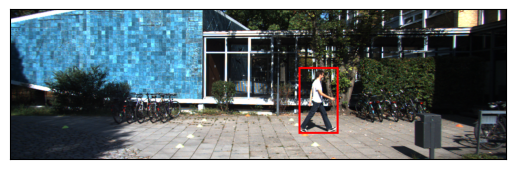

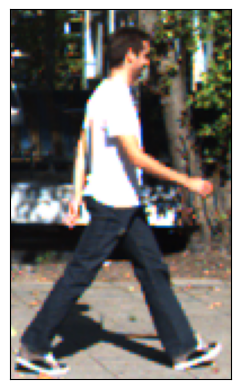

In [9]:
image = training_data[0]
show_image_with_bboxes(image)
bbox_show(image)
get_labels(image)

In [10]:
def get_bbox_area(bbox):
    w = bbox['x2'] - bbox['x1']
    h = bbox['y2'] - bbox['y1']
    return w * h


def get_iou(bbox1, bbox2):
    #   эта функция вычисляет пересечение между пространствами двух bbox

    x_left = max(bbox1['x1'], bbox2['x1'])
    x_right = min(bbox1['x2'], bbox2['x2'])
    y_top = max(bbox1['y1'], bbox2['y1'])
    y_bottom = min(bbox1['y2'], bbox2['y2'])
    
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    
    area = (x_right - x_left) * (y_bottom - y_top)
    
    bb1_area = (bbox1['x2'] - bbox1['x1']) * (bbox1['y2'] - bbox1['y1'])
    bb2_area = (bbox2['x2'] - bbox2['x1']) * (bbox2['y2'] - bbox2['y1'])
    
    iou = float(area) / (bb1_area + bb2_area - area)
    return iou

In [154]:
selSearch = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

def get_regions(image):
    selSearch.setBaseImage(image)
    selSearch.switchToSelectiveSearchFast()
    regions = selSearch.process()
    return regions


def compute_offset(g, p):
    px, py, pw, ph = p['x1'], p['y1'], p['x2'] - p['x1'], p['y2'] - p['y1']
    gx, gy, gw, gh = g['x1'], g['y1'], p['x2'] - g['x1'], g['y2'] - g['y1']
    dx = (gx - px) / pw
    dy = (gy - py) / ph
    dw = np.log(gw / pw)
    dh = np.log(gh / ph)
    return [dx, dy, dw, dh]


training_images = []
training_labels = []
training_bboxes = []

current = 0


def prepare_training_data(data, current):
    
    cvImg = cv2.imread(train_images_path[current])
    image = cv2.cvtColor(cvImg, cv2.COLOR_BGR2RGB)
        
    annotations = get_annotations(data)
    regions = get_regions(image)
    labels = get_labels(data)
        
    imout = image.copy()
        
    flag = 0
    t_counter = 0
    f_counter = 0
    for counter, bbox1 in enumerate(annotations):
        roi = image[bbox1['y1']:bbox1['y2'], bbox1['x1']:bbox1['x2']]
        roi = cv2.resize(roi, (224, 224), interpolation=cv2.INTER_AREA)
        training_images.append(roi)
        training_bboxes.append([0, 0, 0, 0])
        training_labels.append(labels[counter])
            
    for region in regions:
        if flag == 0:
            x, y, w, h = region
            bbox2 = {'x1': x, 'y1': y, 'x2': x+w, 'y2': y+h}
                
            ious = list(map(lambda bbox1: get_iou(bbox1, bbox2), annotations))
            ious = np.array(ious)
                
            ratios = list(map(lambda bbox1: get_bbox_area(bbox1)/get_bbox_area(bbox2), annotations))
                
            ratio_comparable = list(map(lambda r: (r >= 0.7 and r <= 1.3)*1, ratios))
                
            possibleTrue = ((ious > 0.7) * 1).max() == 1
            possibleFalse = ((ious > 0.3) * 1).max() == 0
            if t_counter < 30 and possibleTrue:
                gt = annotations[np.argmax(ious)]
                roi = imout[y:y+h, x:x+w]
                roi = cv2.resize(roi, (224, 224), interpolation=cv2.INTER_AREA)
                offset = compute_offset(gt, bbox2)
                    
                training_images.append(roi)
                training_bboxes.append(offset)
                training_labels.append(labels[np.argmax(ious)])
                t_counter += 1
                
            if f_counter < 12 and possibleFalse and max(ratio_comparable) == 1:
                roi = imout[y:y+h, x:x+w]
                roi = cv2.resize(roi, (224, 224), interpolation=cv2.INTER_AREA)
                training_images.append(roi)
                training_bboxes.append([0, 0, 0, 0])
                training_labels.append(3)
                f_counter += 1
                    
            if t_counter == 30 and f_counter == 12:
                flag = 1
    #return training_images, training_labels, training_bboxes

In [159]:
for i in range(current, len(training_data)):
    print("Processing Image", i+1)
    prepare_training_data(training_data[i], current)
    current += 1

Processing Image 17
Processing Image 18
Processing Image 19
Processing Image 20
Processing Image 21
Processing Image 22
Processing Image 23
Processing Image 24
Processing Image 25
Processing Image 26
Processing Image 27
Processing Image 28
Processing Image 29
Processing Image 30
Processing Image 31
Processing Image 32
Processing Image 33
Processing Image 34
Processing Image 35
Processing Image 36
Processing Image 37
Processing Image 38
Processing Image 39
Processing Image 40
Processing Image 41
Processing Image 42
Processing Image 43
Processing Image 44
Processing Image 45
Processing Image 46
Processing Image 47
Processing Image 48
Processing Image 49
Processing Image 50
Processing Image 51
Processing Image 52
Processing Image 53
Processing Image 54
Processing Image 55
Processing Image 56
Processing Image 57
Processing Image 58
Processing Image 59
Processing Image 60
Processing Image 61
Processing Image 62
Processing Image 63
Processing Image 64
Processing Image 65
Processing Image 66


KeyboardInterrupt: 

[ 3647  4032  9080   376   588 10974]


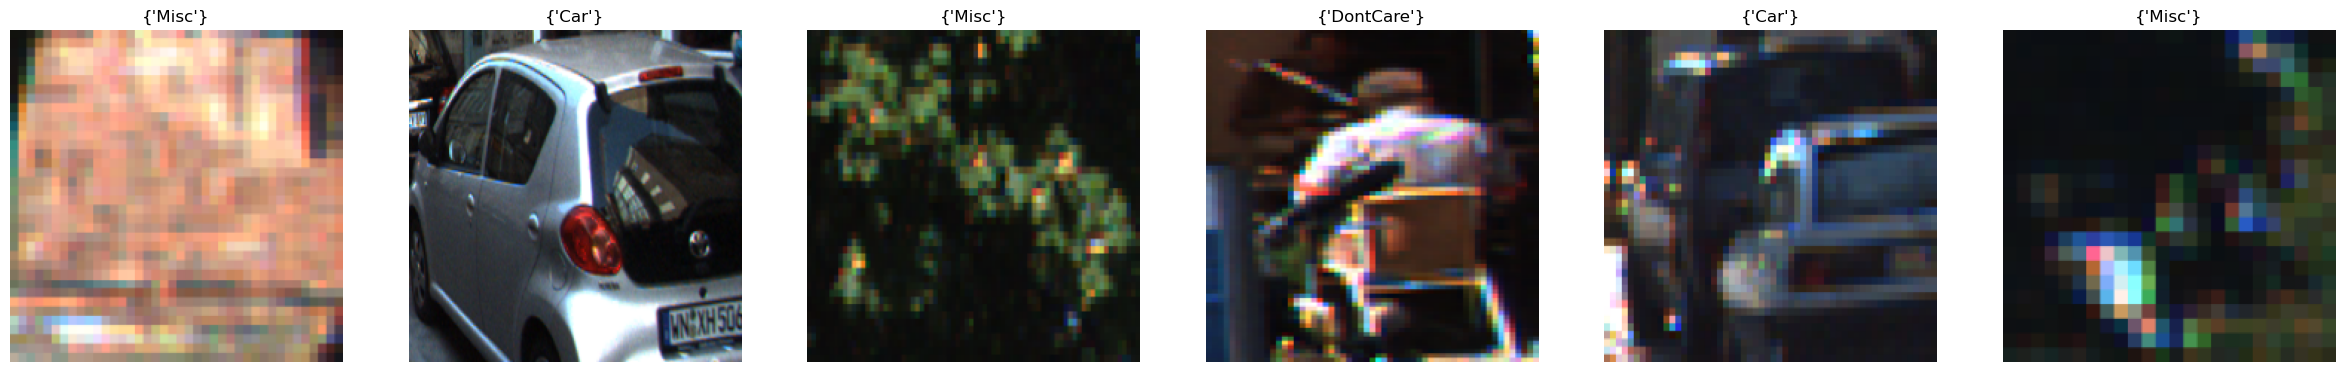

In [164]:
labels = {0: 'Car', 1: 'Cyclist', 2: 'DontCare', 3: 'Misc', 4: 'Pedestrian', 
        5: 'Person_sitting', 6: 'Tram', 7: 'Truck', 8: 'Van'}

indices = np.random.randint(len(training_images), size=(6))
print(indices)
fig, axes = plt.subplots(1, 6, figsize=(30, 5))
for i in range(6):
    axes[i].imshow(training_images[indices[i]])
    axes[i].axis('off')
    axes[i].set_title({labels[training_labels[indices[i]]]})

plt.show()

In [162]:
images = v2.ToDtype(torch.float, scale=True)(torch.from_numpy(np.array(v2.ToTensor()(training_images))))
labels = v2.ToDtype(torch.long)(torch.from_numpy(np.array(training_labels)))
offsets = torch.from_numpy(np.array(training_bboxes))

images.shape, labels.shape, offsets.shape

(torch.Size([11166, 3, 224, 224]), torch.Size([11166]), torch.Size([11166, 4]))

In [16]:
dataset = TensorDataset(images, labels, offsets)

test_size = 1000
train_size = len(dataset) - test_size
train_set, test_set = random_split(dataset, [train_size, test_size])

batch_size = 100
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers = 2, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, num_workers = 2, shuffle=False)

In [157]:
def train_model(dataloader, model, classification_loss_fn, 
                regression_loss_fn, optimizer, callback=None):
    size = len(dataloader.dataset)
    model.train()
    
    for batch, (X, y, of) in enumerate(dataloader):
        X, y, of = X.to(device), y.to(device), of.to(device).float()
        
        logits, bbox_reg = model(X)
        class_loss = classification_loss_fn(logits, y)
        
        pos_indices = y != 3
        if pos_indices.sum() > 0:
            reg_loss = regression_loss_fn(bbox_reg[pos_indices], of[pos_indices])
        else:
            reg_loss = torch.tensor(0.0)
            
        loss = class_loss + reg_loss
        #print(f"Class Loss = {class_loss}; Reg Loss = {reg_loss}; Final Loss = {loss}")
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if callback:
            callback(loss, batch)
            
            
def test_model(dataloader, model, test_type, callback, thresold=0.6):
    size = len(dataloader.dataset)
    model.eval()
    correct = 0
    with torch.no_grad():
        for batch, (X, y, of) in enumerate(dataloader):
            X, y, of = X.to(device), y.to(device), of.to(device).float()
            logits, bbox_reg = model(X)
            logits = nn.functional.softmax(logits)
            pre_probs, pre_labels = torch.max(logits, dim=1)
            valid_pre = pre_probs >= thresold
            #print((pre_labels == y).sum(), valid_pre.sum())
            correct += ((pre_labels == y) & valid_pre).sum().item()
        correct /= size
        accuracy = round(100*correct, 3)
        if callback:
            callback(accuracy)
        print(f"{test_type} Accuracy: {accuracy}%")
        return model, accuracy

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [156]:
class Rcnn(nn.Module):
    def __init__(self, ):
        super(Rcnn, self).__init__()
        
        backbone = models.vgg16(pretrained=True)
        self.features = backbone.features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.fc = nn.Sequential(
            nn.Linear(in_features=25088, out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
        )
        
        self.classifier = nn.Linear(in_features=4096, out_features=9)
        self.regressor = nn.Linear(in_features=4096, out_features=4)
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x) 
        logits = self.classifier(x)
        box_rg = self.regressor(x)
        return logits, box_rg  

In [20]:
model = Rcnn()

In [104]:
for param in model.features.parameters():
    param.requires_grad = True

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay = 1e-5)
classification_loss_fn = nn.CrossEntropyLoss()
regression_loss_fn = nn.MSELoss()

loss_history = []
train_acc = []
test_acc = []

best_model = model
best_acc = 0

num_epochs = 10

def callback(loss, batch):
    if batch % 2 == 0:
        loss_history.append(loss.item())
    if batch % 2 == 0:
        print(f"Batch: {batch}; Loss: {loss.item()}")
    
for epoch in range(num_epochs):
    print(f'----- Epoch {model.current_epoch} -----')
    train_model(train_loader, model, classification_loss_fn, 
                regression_loss_fn, optimizer, callback)
    #test_model(train_loader, model, "Training", lambda acc: train_acc.append(acc), thresold=0.3)
    mod, acc = test_model(test_loader, model, "Testing", lambda acc: test_acc.append(acc), thresold=0.7)
    if acc > best_acc:
        best_acc = acc
        best_model = mod
    torch.save(best_model.cpu().state_dict(), f'models/model_weights_{model.current_epoch}.pth')
    model.current_epoch += 1

In [110]:
mod, acc = test_model(test_loader, model, "Testing", lambda acc: test_acc.append(acc), thresold=0.9)

Testing Accuracy: 87.9%


In [195]:
def get_region_masks(image, regions):
    region_images = []
    region_bboxes = []

    imout = image.copy()
    max_regions = 500
    for e, region in enumerate(regions):
        if (e < max_regions): 
            x, y, w, h = region
            bbox = {'x1': x, 'y1': y, 'x2': x+w, 'y2': y+h}

            roi = imout[y:y+h,x:x+w]
            roi = cv2.resize(roi, (224, 224), interpolation=cv2.INTER_AREA)
            region_images.append(roi)
            region_bboxes.append(bbox)
        else:
            break

    region_images = v2.ToDtype(torch.float, scale=True)(v2.ToTensor()(region_images))
    
    return region_images, region_bboxes


def get_chunks(region_images, chunk_size=200):

    chunks = []
    for i in range(0, len(region_images), chunk_size):
        chunk = region_images[i:i+chunk_size]
        chunks.append(chunk)
    return chunks


def apply_offsets(proposed, offsets):
    px, py, pw, ph = proposed
    dx, dy, dw, dh = offsets
    gx = px + dx * pw
    gy = py + dy * ph
    gw = pw * np.exp(dw)
    gh = ph * np.exp(dh)
    return [gx, gy, gw, gh]


def get_candidates(image, model, chunks, region_bboxes, chunk_size, required_object):
    classes = {'Car': 0, 'Cyclist': 1, 'DontCare': 2, 'Misc': 3, 'Pedestrian': 4, 
    'Person_sitting': 5, 'Tram': 6, 'Truck': 7, 'Van': 8}
    required_label = classes[required_object]
        
    model.eval()
    bboxes = []
    scores = []
    with torch.no_grad():
        for i, X in enumerate(chunks):
            X = torch.from_numpy(np.array(X))
            logits, box_reg = model(X)
            #print(i)
            logits = logits.cpu()
            box_reg = box_reg.cpu()
            logits = nn.functional.softmax(logits, dim=1)
            pre_probs, pre_labels = torch.max(logits, dim=1)
            valid_pre = pre_probs >= 0.8
            correct = ((pre_labels == required_label) & valid_pre).float()
            indices = torch.where(correct == 1)
            for j in range(len(indices[0])):
                bb_i = i*chunk_size + int(indices[0][j])
                box = region_bboxes[bb_i]
                proposed = [box['x1'], box['y1'], box['x2']-box['x1'], box['y2']-box['y1']]
                offset = box_reg[indices[0][j]]
                refined_box = apply_offsets(proposed, offset)
                
                bboxes.append([refined_box[0], refined_box[1], refined_box[0]+refined_box[2], refined_box[1]+refined_box[3]])
                scores.append(pre_probs[indices[0][j]])
    return torch.tensor(bboxes), torch.tensor(scores)


def non_maximum_supression(bboxes, scores, threshold=0.5):
    if len(bboxes) == 0:
        return torch.empty((0,))

    # Coordinates of bounding boxes
    x1 = bboxes[:, 0]
    y1 = bboxes[:, 1]
    x2 = bboxes[:, 2]
    y2 = bboxes[:, 3]
    
    # Compute area of each bounding box
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    
    # Sort the bounding boxes by scores in descending order
    _, order = scores.sort(0, descending=True)
    
    keep = []
    while order.numel() > 0:
        if order.numel() == 1:
            i = order.item()
            keep.append(i)
            break
        else:
            i = order[0].item()
            keep.append(i)

            xx1 = torch.max(x1[i], x1[order[1:]])
            yy1 = torch.max(y1[i], y1[order[1:]])
            xx2 = torch.min(x2[i], x2[order[1:]])
            yy2 = torch.min(y2[i], y2[order[1:]])

            w = torch.clamp(xx2 - xx1 + 1, min=0.0)
            h = torch.clamp(yy2 - yy1 + 1, min=0.0)
            
            inter = w * h
            rem_areas = areas[order[1:]]
            union = (rem_areas - inter) + areas[i]
            IoU = inter / union
            
            inds = (IoU <= threshold).nonzero(as_tuple=False).squeeze()
            order = order[inds + 1]
    
    return torch.tensor(keep, dtype=torch.int64)


def plot_detections(image, selected_bboxes):
    
    image = v2.ToDtype(torch.uint8, scale=True)(v2.ToTensor()(image))
    bboxes = torch.tensor(selected_bboxes, dtype=torch.float)
    result = draw_bounding_boxes(image, bboxes, colors='red', width=5)
    imshow(result)
    

def detect_objects(model, image_ind, required_object, chunk_size=4):
    cvImg = cv2.imread(test_images_path[image_ind])
    image = cv2.cvtColor(cvImg, cv2.COLOR_BGR2RGB)
    regions = get_regions(image)
    #print(len(regions))
    region_images, region_bboxes = get_region_masks(image, regions)
    chunks = get_chunks(region_images, chunk_size)
    bboxes, scores = get_candidates(image, model, chunks, region_bboxes, chunk_size, required_object)
    keep_indices = non_maximum_supression(bboxes, scores, threshold=0.6)
    selected_bboxes = bboxes[keep_indices]
    selected_scores = scores[keep_indices]
    
    
    plot_detections(image, selected_bboxes)

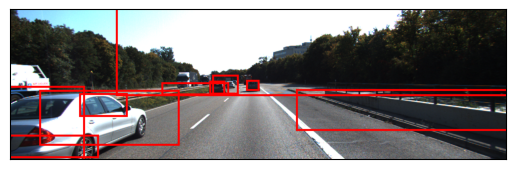

In [196]:
#Пример
detect_objects(model, image_ind=10, required_object='Car')